In [1]:
# !pip install folktables

In [2]:
from folktables import ACSIncome, ACSEmployment, ACSTravelTime, ACSDataSource
import numpy as np
import folktables
import pandas as pd
from DPL.RegularizationLoss import RegularizationLoss
import torch
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
import dill

In [3]:
data_source = ACSDataSource(survey_year="2014", horizon="5-Year", survey="person")

In [4]:
def create_employment_dataset():
    ACSEmployment = folktables.BasicProblem(
        features=[
            "AGEP",
            "SCHL",
            "MAR",
            "RELP",
            "DIS",
            "ESP",
            "CIT",
            "MIG",
            "MIL",
            "ANC",
            "NATIVITY",
            "DEAR",
            "DEYE",
            "DREM",
            "SEX",
            "RAC1P",
        ],
        target="ESR",
        target_transform=lambda x: x == 1,
        group="SEX",
        preprocess=lambda x: x,
        postprocess=lambda x: np.nan_to_num(x, -1),
    )
    # states = None
    # for year in [2014, 2015, 2016, 2017, 2018, 2019]:
    year = 2014
    states = ["AL"]
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=states, download=True)
    features, label, group = ACSEmployment.df_to_numpy(acs_data)
    feature_pd, label_pd, group_pd = ACSEmployment.df_to_pandas(acs_data)
    return features, label, group, feature_pd, label_pd, group_pd


def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df["AGEP"] > 16]
    df = df[df["PINCP"] > 100]
    df = df[df["WKHP"] > 0]
    df = df[df["PWGTP"] >= 1]
    return df


def create_income_dataset():
    ACSIncome = folktables.BasicProblem(
        features=[
            "AGEP",
            "COW",
            "SCHL",
            "MAR",
            "OCCP",
            "POBP",
            "RELP",
            "WKHP",
            "SEX",
            "RAC1P",
        ],
        target="PINCP",
        target_transform=lambda x: x > 50000,
        group="SEX",
        preprocess=adult_filter,
        postprocess=lambda x: np.nan_to_num(x, -1),
    )

    data = {}

    state_list = [
        "AL",
        "AK",
        "AZ",
        "AR",
        "CA",
        "CO",
        "CT",
        "DE",
        "FL",
        "GA",
        "HI",
        "ID",
        "IL",
        "IN",
        "IA",
        "KS",
        "KY",
        "LA",
        "ME",
        "MD",
        "MA",
        "MI",
        "MN",
        "MS",
        "MO",
        "MT",
        "NE",
        "NV",
        "NH",
        "NJ",
        "NM",
        "NY",
        "NC",
        "ND",
        "OH",
        "OK",
        "OR",
        "PA",
        "RI",
        "SC",
        "SD",
        "TN",
        "TX",
        "UT",
        "VT",
        "VA",
        "WA",
        "WV",
        "WI",
        "WY",
        "PR",
    ]
    for year in [2014, 2015, 2016, 2017, 2018, 2019]:
        for state in state_list:
            data_source = ACSDataSource(
                survey_year=year, horizon="1-Year", survey="person"
            )
            acs_data = data_source.get_data(states=[state], download=True)
            try:
                features, label, group = ACSIncome.df_to_numpy(acs_data)
                feature_pd, label_pd, group_pd = ACSIncome.df_to_pandas(acs_data)
                if state not in data:
                    data[state] = {}
                    data[state]["features"] = features
                    data[state]["labels"] = label
                    data[state]["groups"] = group
                    data[state]["features_pd"] = feature_pd
                    data[state]["labels_pd"] = label_pd
                    data[state]["groups_pd"] = group_pd
                else:
                    data[state]["features"] = np.concatenate(
                        (data[state]["features"], features), axis=0
                    )
                    data[state]["labels"] = np.concatenate(
                        (data[state]["labels"], label), axis=0
                    )
                    data[state]["groups"] = np.concatenate(
                        (data[state]["groups"], group), axis=0
                    )
                    data[state]["features_pd"] = pd.concat(
                        (data[state]["features_pd"], feature_pd), axis=0
                    )
                    data[state]["labels_pd"] = pd.concat(
                        (data[state]["labels_pd"], label_pd), axis=0
                    )
                    data[state]["groups_pd"] = pd.concat(
                        (data[state]["groups_pd"], group_pd), axis=0
                    )
            except:
                print("Error with state: ", state, " and year: ", year)

    return data

In [5]:
# data = create_income_dataset()

In [6]:
def plot_disparity(disparities):
    # plot the disparities of the different states

    fig = plt.figure(figsize=(20, 10))
    plt.bar(range(len(disparities)), list(disparities.values()), align="center")
    plt.xticks(range(len(disparities)), list(disparities.keys()))
    plt.xlabel("State")
    plt.ylabel("Disparity")
    plt.title("Income Disparity")
    plt.show()


def plot_bar_plot(data):
    # plot a bar plot of the different <label, group> pairs for each state
    clients_target_sensitive = []
    for state in data.keys():
        labels = data[state]["labels"].astype(int)
        group = [1 if item == 1 else 0 for item in list(data[state]["groups"])]

        labels_and_group = list(zip(labels, group))
        clients_target_sensitive.append(labels_and_group)

    counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
    print(counter_groups[0])
    print(counter_groups[-1])
    counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
    counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
    counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
    counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

    # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
    # for each client in the same plot
    plt.figure(figsize=(20, 8))

    plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
    plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
    plt.bar(
        range(len(counter_group_1_0)),
        counter_group_1_0,
        bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)],
    )
    plt.bar(
        range(len(counter_group_1_1)),
        counter_group_1_1,
        bottom=[
            sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)
        ],
    )

    plt.xlabel("Client")
    plt.ylabel("Amount of samples")
    plt.title("Samples for each group (target/sensitive Value) per client")
    plt.legend(["0,0", "0,1", "1,0", "1,1"])
    # font size 20
    plt.rcParams.update({"font.size": 20})
    plt.tight_layout()

    # group_to_reduce=(0,1), group_to_increment=(1,1),
    # 0, 0 -> 1, 0

# Income

In [7]:
# read file
dill_file = open("income_data.pkd", "rb")
data = dill.load(dill_file)
disparities = {}
for state in data.keys():
    labels = torch.tensor(data[state]["labels"].astype(int))
    group = torch.tensor(
        [1 if item == 1 else 0 for item in list(data[state]["groups"])]
    )
    max_disparity = np.max(
        [
            RegularizationLoss().compute_violation_with_argmax(
                predictions_argmax=labels,
                sensitive_attribute_list=group,
                current_target=target,
                current_sensitive_feature=sv,
            )
            for target in range(0, 1)
            for sv in range(0, 1)
        ]
    )
    disparities[state] = max_disparity

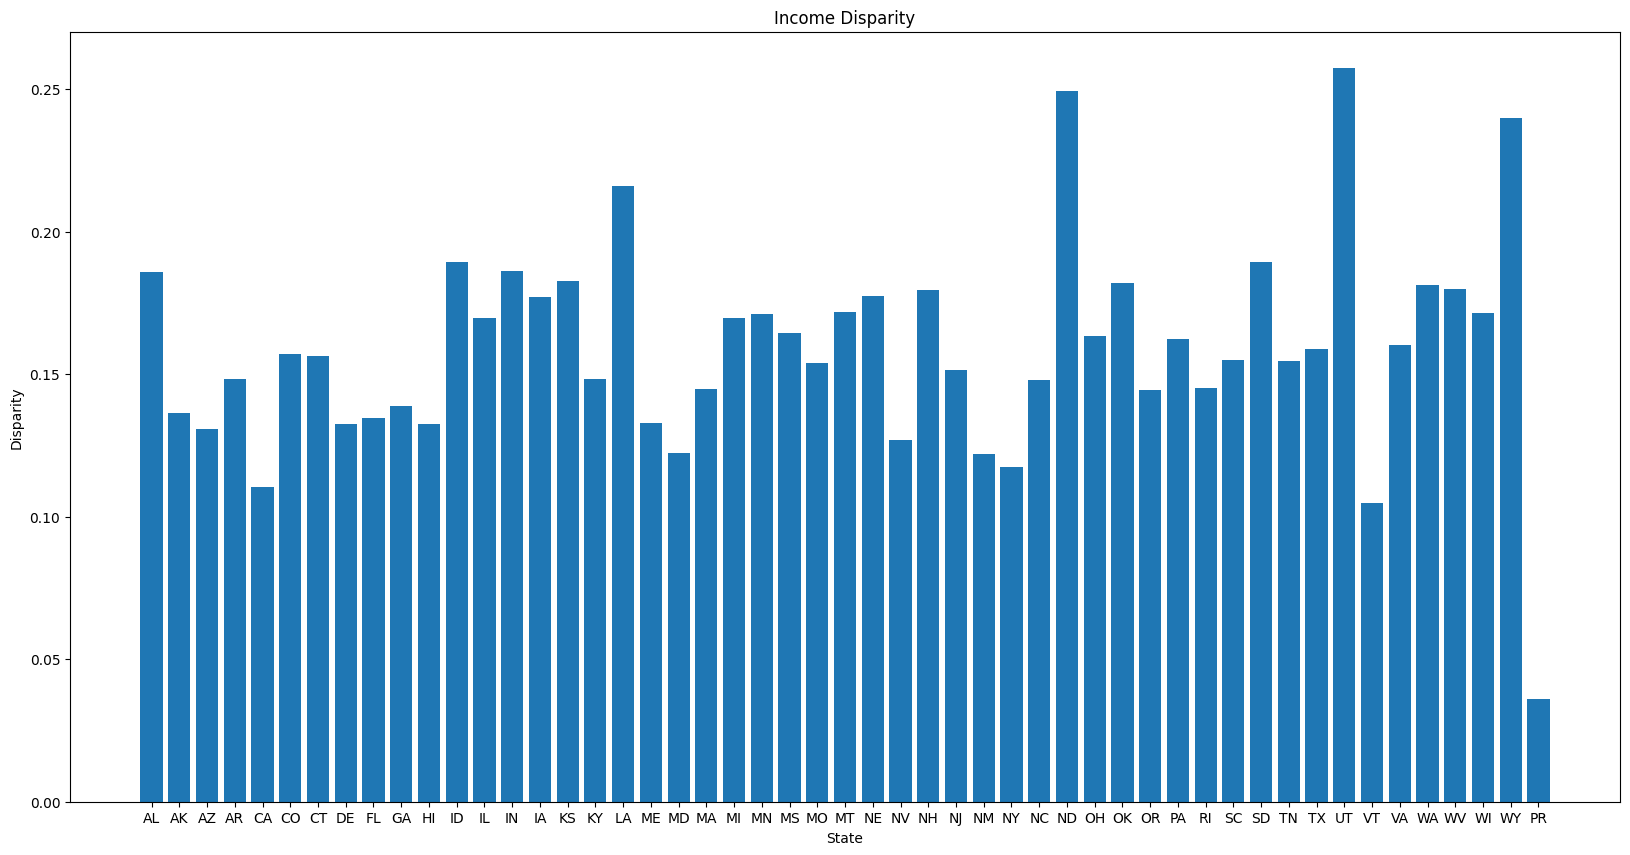

In [ ]:
plot_disparity(disparities)

In [ ]:
np.mean(list(disparities.values()))

0.15922403036008806

Counter({(0, 0): 42781, (0, 1): 35682, (1, 1): 21611, (1, 0): 10119})
Counter({(0, 1): 20745, (0, 0): 19562, (1, 1): 2786, (1, 0): 1752})


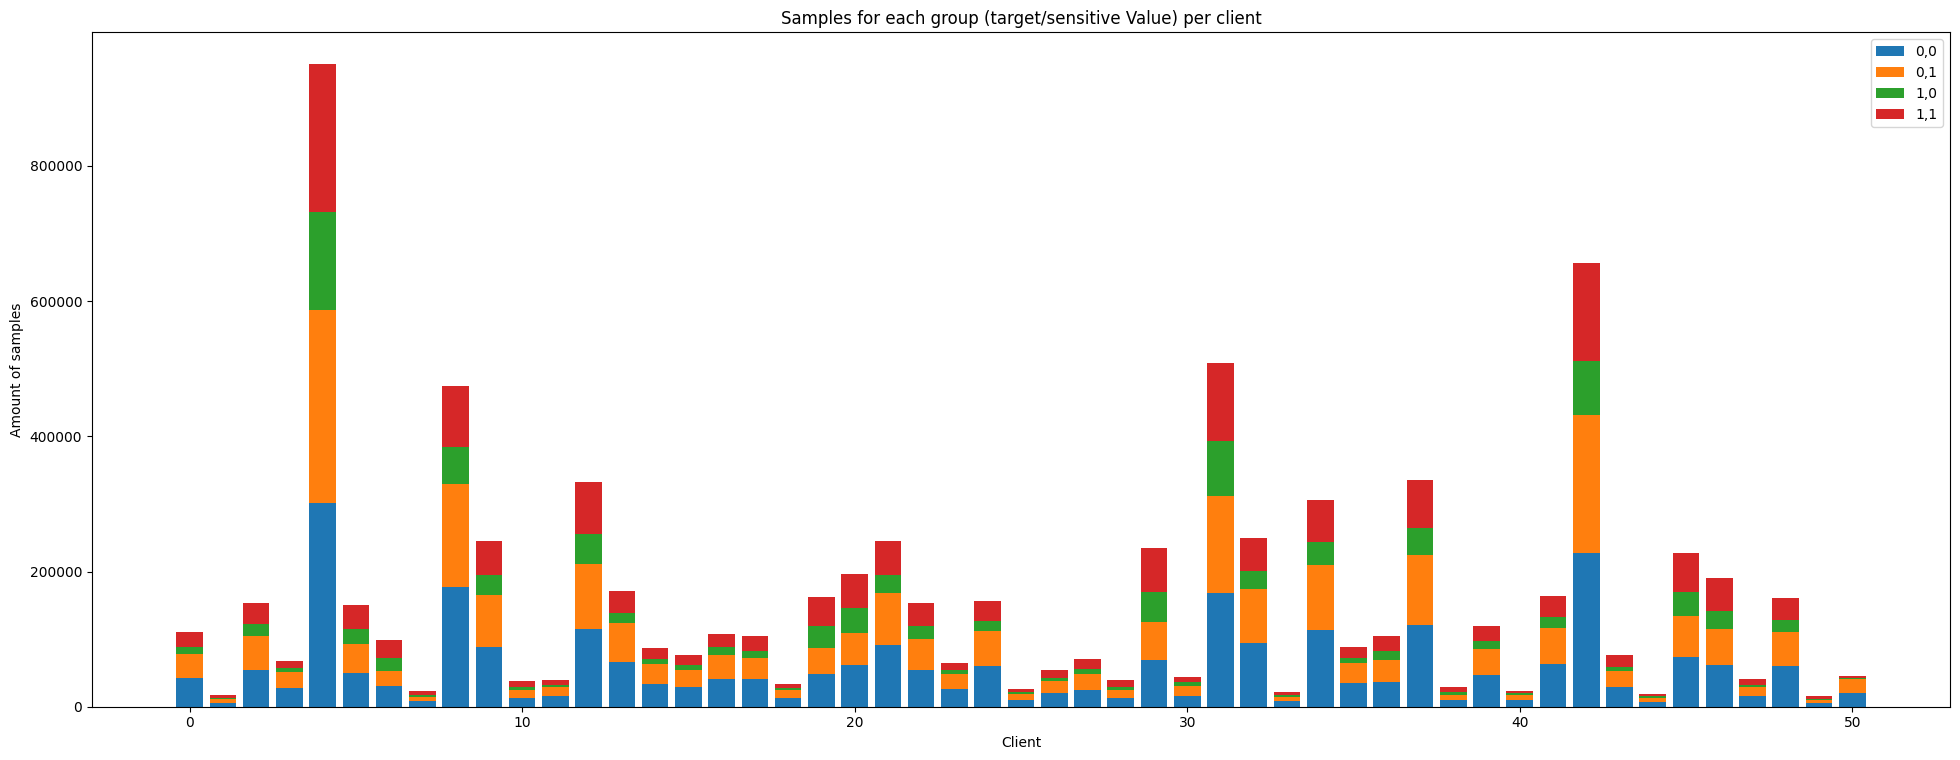

In [ ]:
plot_bar_plot(data)

In [ ]:
data

In [ ]:
test_set = [
    int(item) for item in ["23", "45", "13", "15", "8", "33", "7", "2", "35", "3"]
]
train_set = [
    int(item)
    for item in [
        "19",
        "32",
        "39",
        "27",
        "0",
        "47",
        "24",
        "11",
        "4",
        "46",
        "20",
        "48",
        "12",
        "31",
        "14",
        "49",
        "21",
        "16",
        "22",
        "9",
        "29",
        "38",
        "40",
        "36",
        "25",
        "37",
        "42",
        "34",
        "5",
        "17",
        "50",
    ]
]
valiation_set = [
    int(item) for item in ["30", "28", "10", "44", "18", "43", "26", "6", "41", "1"]
]

In [12]:
all_data = None
all_labels = None
all_groups = None

for state in data.keys():
    # extend the all_data, all_labels, all_groups pandas dataframe with the data from the current state
    if all_data is None:
        all_data = data[state]["features_pd"]
        all_labels = data[state]["labels_pd"]
        all_groups = data[state]["groups_pd"]
    else:
        all_data = pd.concat((all_data, data[state]["features_pd"]), axis=0)
        all_labels = pd.concat((all_labels, data[state]["labels_pd"]), axis=0)
        all_groups = pd.concat((all_groups, data[state]["groups_pd"]), axis=0)

In [13]:
all_data.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,49.0,6.0,16.0,1.0,7210.0,1.0,0.0,60.0,1.0,1.0
1,51.0,1.0,16.0,1.0,4220.0,1.0,0.0,40.0,1.0,1.0
2,53.0,1.0,16.0,1.0,7750.0,1.0,1.0,40.0,2.0,1.0
3,51.0,1.0,16.0,1.0,5610.0,19.0,0.0,40.0,1.0,1.0
4,48.0,5.0,20.0,1.0,7430.0,47.0,1.0,40.0,2.0,1.0


# Employment 

In [80]:
# read file
dill_file = open("employment_data.pkd", "rb")
data = dill.load(dill_file)
disparities = {}
for state in data.keys():
    labels = torch.tensor(data[state]["labels"].astype(int))
    group = torch.tensor(
        [1 if item == 1 else 0 for item in list(data[state]["groups"])]
    )
    max_disparity = np.max(
        [
            RegularizationLoss().compute_violation_with_argmax(
                predictions_argmax=labels,
                sensitive_attribute_list=group,
                current_target=target,
                current_sensitive_feature=sv,
            )
            for target in range(0, 1)
            for sv in range(0, 1)
        ]
    )
    disparities[state] = max_disparity

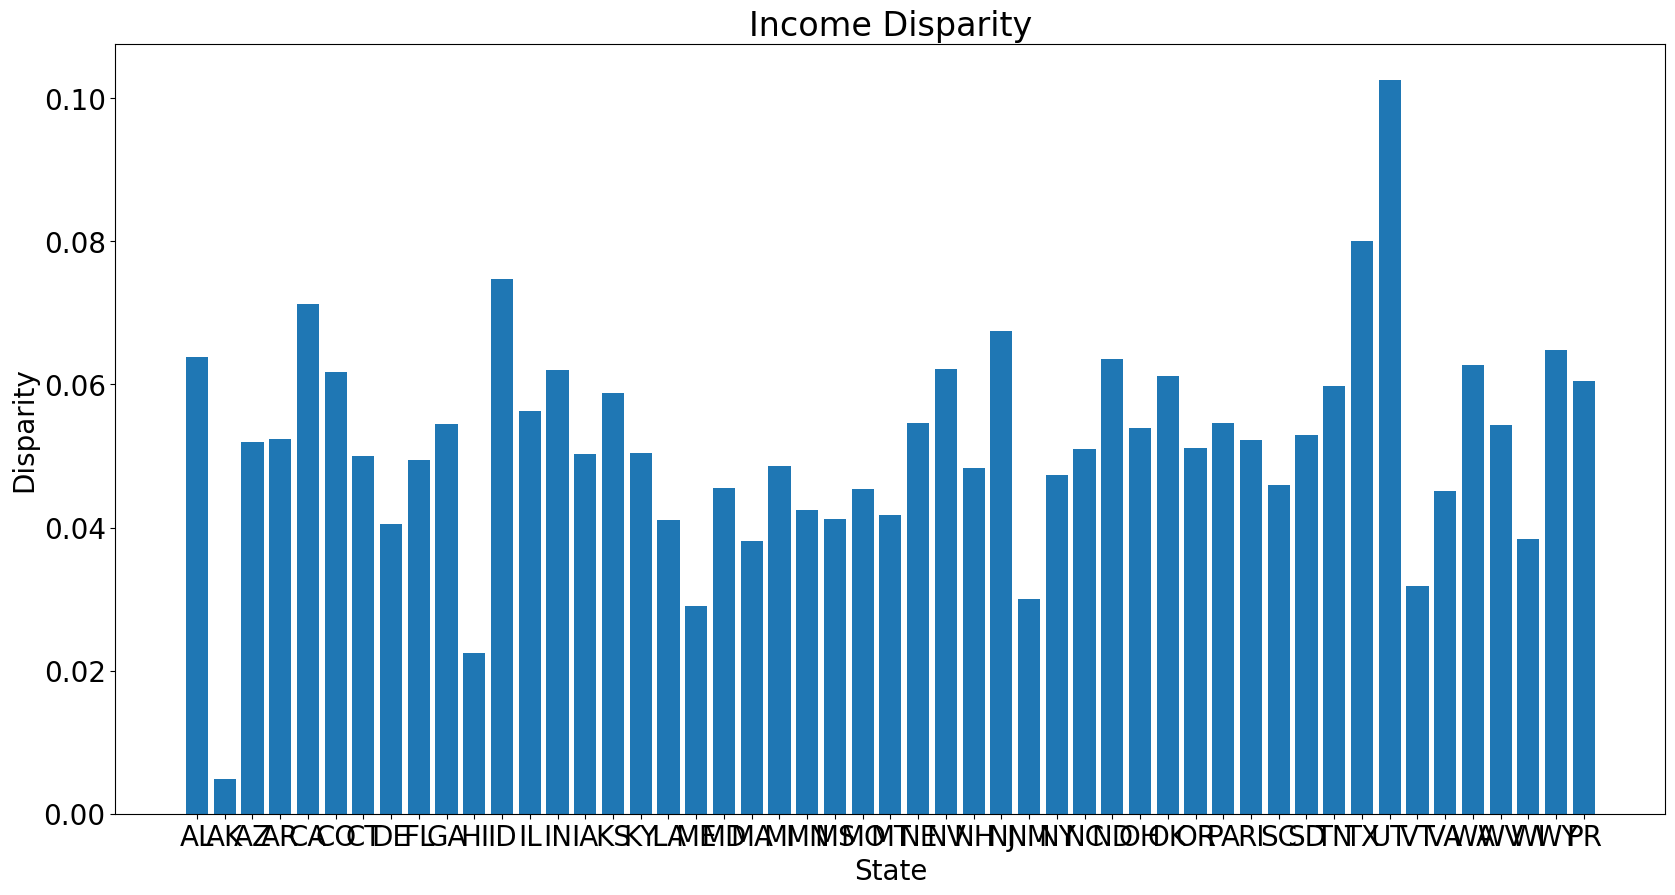

In [81]:
plot_disparity(disparities)

Counter({(0, 0): 77892, (0, 1): 64596, (1, 1): 49811, (1, 0): 46051})
Counter({(0, 0): 56301, (0, 1): 45508, (1, 1): 20745, (1, 0): 19032})


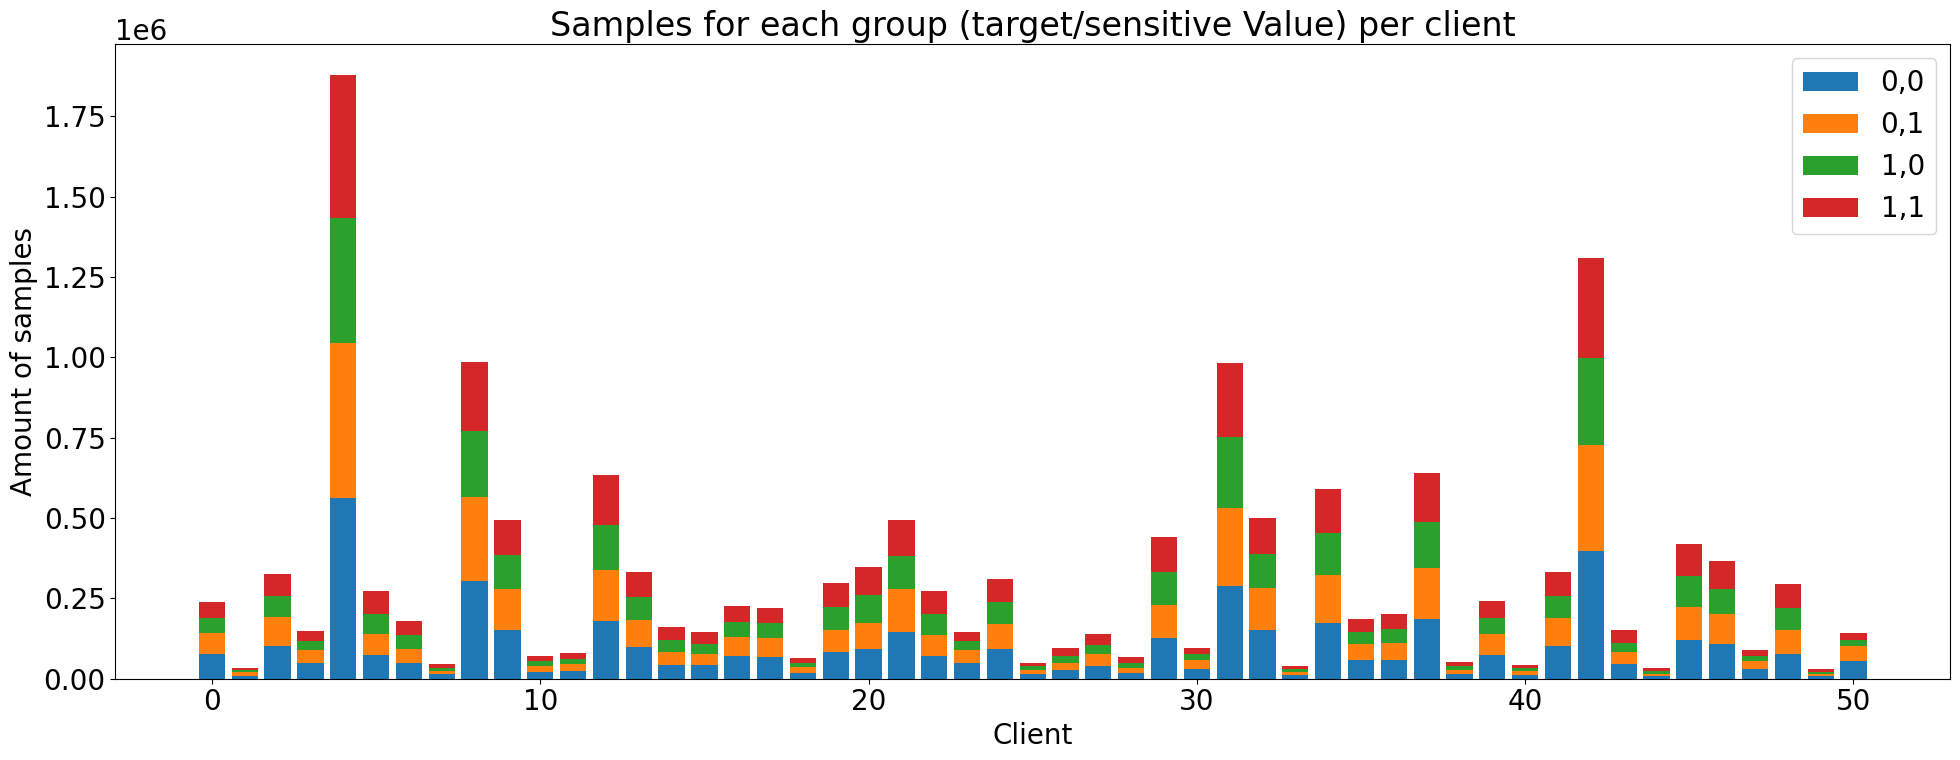

In [82]:
plot_bar_plot(data)